# Gradient Boosting - Women Risk Predictor

In [1]:
# Import required libraries for data processing, modeling, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import joblib
import os

In [2]:
# Load the processed dataset
fp = pd.read_csv("../data/women_risk_processed.csv")

In [3]:
# Display first few rows
fp.head()

,Timestamp,1. What is your age group?,2. What is your occupation?,3. At what time of day did the incident occur?,4. Where did the incident occur?,5. How crowded was the location at the time of the incident?,6. What was the lighting condition in the area?,7. Was any form of security present at the location?,8. Were you familiar with the area where the incident occurred?,9. What type of harassment did you experience?,10. How often have you experienced harassment in similar situations?,11. How safe did you feel during the incident?,"12. Overall, how would you rate the risk level of harassment in that situation?"
0,-1.717054,-1.101957,0.768289,0.050825,0.447315,1.626236,-0.035267,0.638877,0.438805,-0.086657,0.886103,-0.205660,2.179449
1,-1.686931,-1.101957,0.768289,0.050825,-0.369212,-1.378055,0.775880,0.638877,1.130072,-0.086657,-1.843410,2.328366,1.300022
2,-1.656807,-1.101957,0.768289,1.512033,-1.185740,0.875163,1.587028,0.638877,-0.943731,-0.917117,0.886103,1.483691,1.300022
3,-1.626683,-1.101957,0.768289,1.512033,-0.369212,-1.378055,0.775880,0.638877,0.438805,-0.086657,-0.023735,1.483691,-1.338258
4,-1.596559,-0.233977,0.038097,-0.679780,0.447315,0.124090,-0.035267,1.557262,-0.252463,1.574264,0.886103,1.483691,-1.338258


In [4]:
# Check dataset shape (rows, columns)
fp.shape

(115, 13)

In [5]:
# Prepare features (X) and target (y)
target_col = '12. Overall, how would you rate the risk level of harassment in that situation?'
X = fp.drop(target_col, axis=1)
y = fp[target_col]

# Convert target to binary: High (1) if above median, Low (0) otherwise
y = (y > y.median()).astype(int)

In [6]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Initialize Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

In [8]:
# Train the model on training data
model.fit(X_train, y_train)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 

In [9]:
# Make predictions on test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability for positive class

In [10]:
# Calculate accuracy score
accuracy_score(y_test, y_pred)

0.9565217391304348

In [11]:
# Calculate precision score
precision_score(y_test, y_pred)

1.0

In [12]:
# Calculate recall score
recall_score(y_test, y_pred)

0.75

In [13]:
# Calculate F1 score
f1_score(y_test, y_pred)

0.8571428571428571

In [14]:
# Calculate ROC-AUC score
roc_auc_score(y_test, y_pred_proba)

0.9605263157894737

In [15]:
# Print detailed classification report
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.95      1.00      0.97        19\n           1       1.00      0.75      0.86         4\n\n    accuracy                           0.96        23\n   macro avg       0.97      0.88      0.92        23\nweighted avg       0.96      0.96      0.95        23\n'

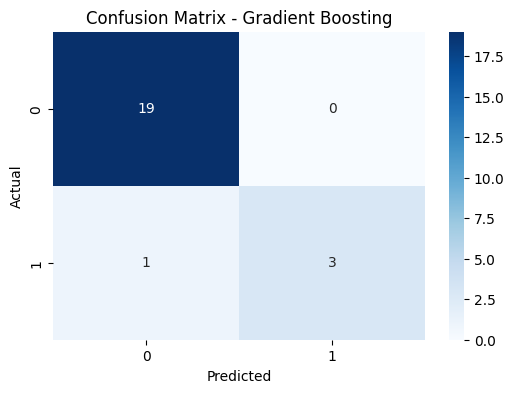

In [16]:
# Create and visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

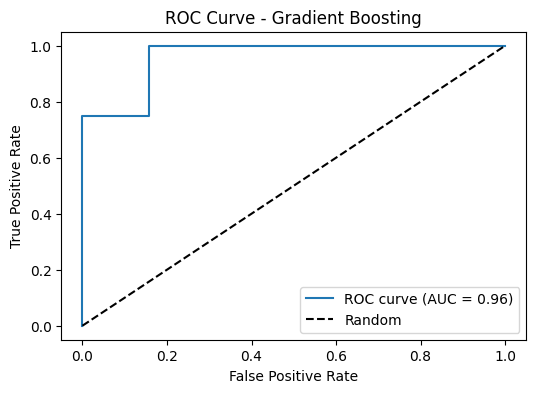

In [17]:
# Plot ROC curve to visualize model performance
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.show()

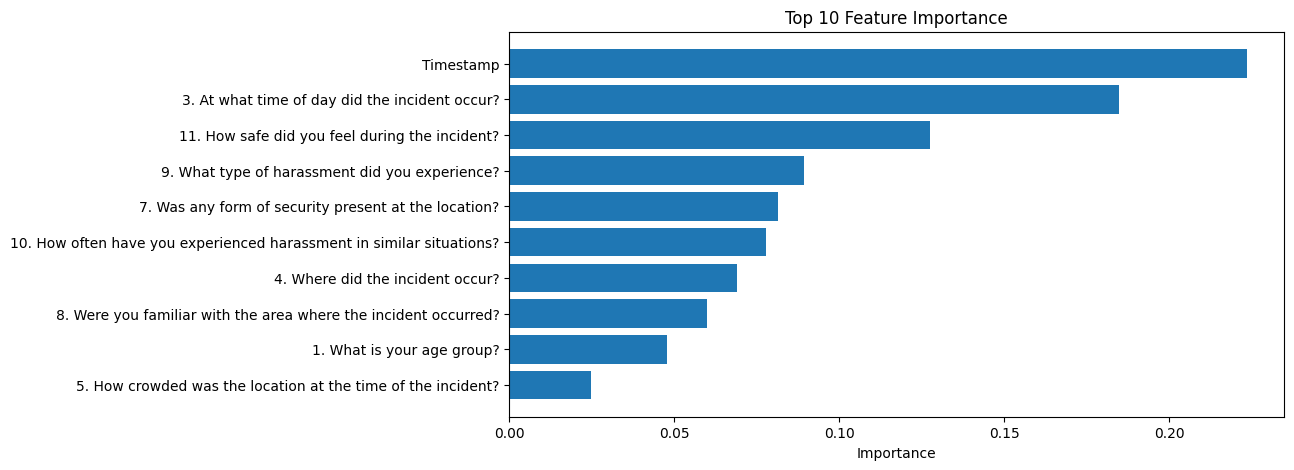

In [18]:
# Display top 10 most important features
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Hyperparameter Tuning

In [19]:
# Define hyperparameter grid for tuning
param_grid = {
    "n_estimators": [50, 100, 200],         # Number of boosting stages
    "learning_rate": [0.01, 0.1, 0.2],      # Learning rate shrinks contribution
    "max_depth": [3, 5, 7],                  # Maximum depth of trees
    "min_samples_split": [2, 5, 10]         # Minimum samples to split node
}

In [20]:
# Initialize GridSearchCV for hyperparameter tuning
grid = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [21]:
# Perform grid search to find best hyperparameters
grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",GradientBoost...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and

In [22]:
# Display best parameters and cross-validation accuracy
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}
Best CV accuracy: 0.8812865497076023


In [23]:
# Get the best model from grid search
best_model = grid.best_estimator_

In [24]:
# Make predictions using tuned model
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

In [25]:
# Calculate accuracy of tuned model
accuracy_score(y_test, y_pred_tuned)

0.9565217391304348

In [26]:
# Print classification report for tuned model
classification_report(y_test, y_pred_tuned)

'              precision    recall  f1-score   support\n\n           0       0.95      1.00      0.97        19\n           1       1.00      0.75      0.86         4\n\n    accuracy                           0.96        23\n   macro avg       0.97      0.88      0.92        23\nweighted avg       0.96      0.96      0.95        23\n'

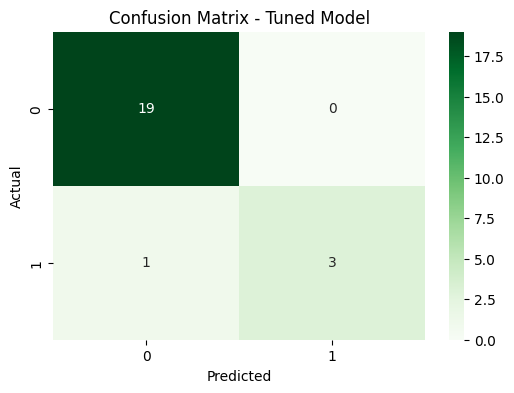

In [27]:
# Visualize confusion matrix for tuned model
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Tuned Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

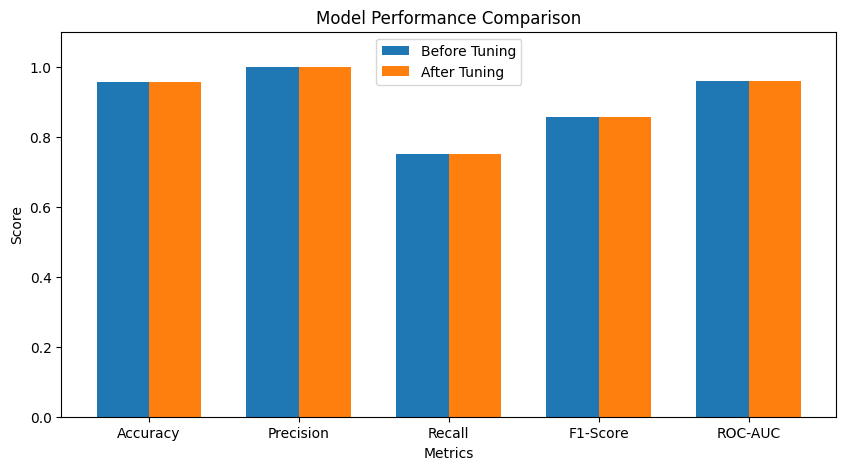

In [28]:
# Compare performance before and after tuning
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
before = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), 
          recall_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred_proba)]
after = [accuracy_score(y_test, y_pred_tuned), precision_score(y_test, y_pred_tuned), 
         recall_score(y_test, y_pred_tuned), f1_score(y_test, y_pred_tuned), roc_auc_score(y_test, y_pred_proba_tuned)]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, before, width, label='Before Tuning')
plt.bar(x + width/2, after, width, label='After Tuning')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim([0, 1.1])
plt.show()

## Save Model

In [29]:
# Save the best model to file
os.makedirs('../models', exist_ok=True)
joblib.dump(best_model, '../models/gradient_boosting_model.pkl')
print("Model saved!")

Model saved!
